In [127]:
import torch
import torchvision
import matplotlib.pyplot as plt
import os
from PIL import Image
import json
import torch
import pathlib
from pathlib import Path
import PixelEncoder
from typing import Tuple, Dict, List
from torch.utils.data import DataLoader
from torchvision import transforms
import numpy as np
import math
from math import sqrt
from tqdm.auto import tqdm
import PixelEncoder
from PixelEncoder import PixelEncodingSet, Segments, pointToPixel, pixelToPoint
import torch.nn.functional as F


magnitude = np.linalg.norm

In [128]:
# GLOBAL VARIABLES

model_path = f"/Users/mary/Documents/School/Sketch Simplification/sketch_simplification_2/model/model.pt"

data_path = Path(
    f"/Users/mary/Documents/School/Sketch Simplification/sketch_simplification_2/dataset"
)

flower_data_path = Path(
    f"/Users/mary/Documents/School/Sketch Simplification/Sketch-Simplification/disposable/data"
)

device = "mps"

T = 5
IMG_SIZE = 200
BATCH_SIZE = 30


def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    return torch.linspace(start, end, timesteps)


# Define beta schedule
betas = linear_beta_schedule(timesteps=T)

# Pre-calculate different terms for closed form
alphas = 1.0 - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod)
posterior_variance = betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod)

In [129]:
class SketchData(torch.utils.data.Dataset):
    """
    Custom PyTorch dataset for image and JSON pairs.

    Args:
        root_dir (str): Path to the root directory containing image folders.
        transform (callable, optional): A function/transform to apply to the image.
    """

    def __init__(self, targ_dir, transform=None):
        self.paths = list(targ_dir.glob("*/."))

        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index: int):
        "Returns one sample of data, data and label (X, y)."

        data_path = self.paths[index]

        img = Image.open(data_path / Path("base.png")).convert("L")

        assert img.size == (IMG_SIZE, IMG_SIZE), f"Image size must = {IMG_SIZE}"
        if self.transform:
            # return data, label (X, y)
            return self.transform(img), index
        else:
            return img, index

    def getOtherData(self, index: int):
        data_path = self.paths[index]
        pixe_set = PixelEncodingSet.load(data_path / Path("pixe_set.json"))
        segs = Segments.load(data_path / Path("segs.json"), fromBlender=False)
        return pixe_set, segs

    def getSegs(self, index: int):
        data_path = self.paths[index]
        segs = Segments.load(data_path / Path("segs.json"), fromBlender=False)
        return segs

    def get_pixe_set(self, index: int):
        data_path = self.paths[index]
        pixe_set = PixelEncodingSet.load(data_path / Path("pixe_set.json"))
        return pixe_set


data = SketchData(targ_dir=data_path)
data.getOtherData(0)

(<PixelEncoder.PixelEncodingSet at 0x2907bf0d0>,
 <PixelEncoder.Segments at 0x291b67610>)

In [130]:
# # FLOWERS DATASET

# data = torchvision.datasets.data = torchvision.datasets.Flowers102(
#     root=flower_data_path,
#     download=True,
# )

In [131]:
from torch import nn
import math


class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp = nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2 * in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU()

    def forward(
        self,
        x,
        t,
    ):
        # First Conv
        h = self.bnorm1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(...,) + (None,) * 2]
        # Add time channel
        h = h + time_emb
        # Second Conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)


class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        # TODO: Double check the ordering here
        return embeddings


class SimpleUnet(nn.Module):
    """
    A simplified variant of the Unet architecture.
    """

    def __init__(self):
        super().__init__()
        image_channels = 1
        down_channels = (
            IMG_SIZE,
            IMG_SIZE * 2,
            IMG_SIZE * 2**2,
            IMG_SIZE * 2**3,
            IMG_SIZE * 2**4,
        )
        up_channels = (
            IMG_SIZE * 2**4,
            IMG_SIZE * 2**3,
            IMG_SIZE * 2**2,
            IMG_SIZE * 2,
            IMG_SIZE,
        )
        out_dim = 2
        time_emb_dim = 32

        # Time embedding
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.ReLU(),
        )

        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList(
            [
                Block(down_channels[i], down_channels[i + 1], time_emb_dim)
                for i in range(len(down_channels) - 1)
            ]
        )
        # Upsample
        self.ups = nn.ModuleList(
            [
                Block(up_channels[i], up_channels[i + 1], time_emb_dim, up=True)
                for i in range(len(up_channels) - 1)
            ]
        )

        # Edit: Corrected a bug found by Jakub C (see YouTube comment)
        self.output = nn.Conv2d(up_channels[-1], out_dim, 1)

    def forward(self, x, timestep):
        # Embedd time
        t = self.time_mlp(timestep)
        # Initial conv
        x = self.conv0(x)
        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            # Add residual x as additional channels
            x = torch.cat((x, residual_x), dim=1)
            x = up(x, t)
        return self.output(x)


model = SimpleUnet()
if os.path.exists(model_path):
    state_dict = torch.load(model_path)
    model.load_state_dict(state_dict)

print("Num params: ", sum(p.numel() for p in model.parameters()))

Num params:  62437666


In [132]:
def transform_data(data):
    data_transforms = transforms.Compose(
        [
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor(),
        ]
    )
    return SketchData(data_path, data_transforms)


def img_to_tensor(img):
    data_transforms = transforms.Compose(
        [
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor(),
        ]
    )
    return data_transforms(img)


def tensor_to_img(image):
    reverse_transforms = transforms.Compose([transforms.ToPILImage()])
    return reverse_transforms(image)


def show_tensor_image(image):
    plt.imshow(tensor_to_img(image))


# data = img_to_tensor(data)


# plt.figure(figsize=(15, 15))
# plt.axis("off")
# num_images = 10
# stepsize = int(T / num_images)


# for idx in range(0, T, stepsize):
#     t = torch.Tensor([idx]).type(torch.int64)
#     plt.subplot(1, num_images + 1, int(idx / stepsize) + 1)
#     img = next(iter(data))[0]
#     # print(img)
#     show_tensor_image(img)
# # print(img.shape)

indexes =  tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])


/var/folders/kb/_q7h1gjd3hg5np_ldqm81hdc0000gn/T/ipykernel_28154/246330527.py:99: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


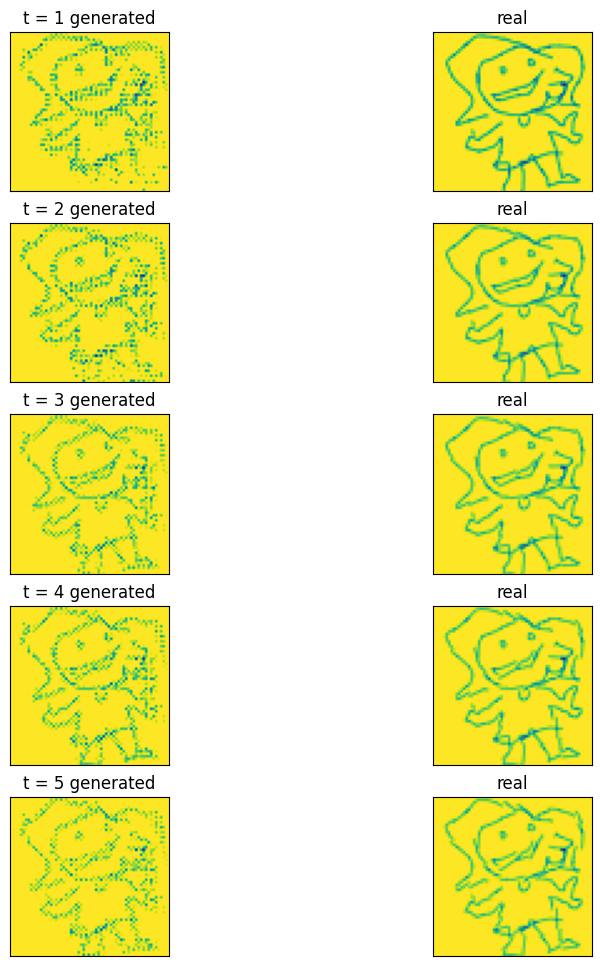

In [137]:
# ---- Model demo before training ----


# TODO fix the offsets
def applyOffsets(img, offsets):
    # make the offsets in the format (pixel index y, pixel index x, channel)
    offsets = offsets.permute(1, 2, 0)
    offsets = offsets.cpu().numpy()

    # make an array that is filled with points

    # apply the offsets to the points, then convert everything to pixels

    def insideImg(x, y):
        return x >= 0 and x < IMG_SIZE and y >= 0 and y < IMG_SIZE

    def mix(v0, v1):
        return round(((v0 + v1) / 2))

    img_0 = tensor_to_img(img)
    img_1 = Image.new("L", (IMG_SIZE, IMG_SIZE), 255)
    pixels_0, pixels_1 = img_0.load(), img_1.load()

    for x in range(IMG_SIZE):
        for y in range(IMG_SIZE):
            x_point, y_point = pixelToPoint(x, IMG_SIZE), pixelToPoint(y, IMG_SIZE)
            x_delta, y_delta = offsets[y, x]

            x_point_new, y_point_new = x_point + x_delta, y_point + y_delta
            x_new, y_new = pointToPixel(x_point_new, IMG_SIZE), pointToPixel(
                y_point_new, IMG_SIZE
            )
            if insideImg(x_new, y_new):
                newColor = mix(pixels_0[x, y], pixels_1[x_new, y_new])
                pixels_1[x_new, y_new] = newColor
    return img_1


def getRealOffsets(img_index, timesteps):
    # returns the offsets needed to get to the prev timestep
    def get_points_at_t(segs, t):
        segs_t = PixelEncoder.generateSketchSegs(segs, t / T)
        points_t = pixe_set.get_points(segs_t)
        return points_t

    # init variables
    timesteps = timesteps.cpu().numpy()
    maxTimestep = timesteps.max()
    segs = data.getSegs(img_index)
    pixe_set = data.get_pixe_set(img_index)

    offsets = []
    points_last = get_points_at_t(segs, 0)
    offsets.append(np.zeros((IMG_SIZE, IMG_SIZE, 2)))
    for t in range(1, maxTimestep + 1):
        points_t = get_points_at_t(segs, t)
        offsets_t = points_t - points_last
        offsets_pixels_t = PixelEncoder.pointToPixel(offsets_t, IMG_SIZE)
        offsets_pixels_t = offsets_t.reshape(IMG_SIZE, IMG_SIZE, 2)
        offsets.append(offsets_pixels_t)
        points_last = points_t

    offsets = np.array(offsets)
    return torch.tensor([offsets[t] for t in timesteps]).permute(0, 3, 1, 2)


def showDifferences(img_index, out_offsets, real_offsets, timesteps, max_dps=5):
    segs = data.getSegs(img_index)

    dps = min(len(out_offsets), max_dps)
    fig, ax = plt.subplots(dps, 2, figsize=(10, 12))

    real_offsets_numpy = real_offsets.cpu().numpy()

    for i in range(dps):
        t = timesteps[i].item()
        t_norm = t / T
        goal_t_norm = max(0, (t - 1) / T)

        segsBaked_start = PixelEncoder.generateSketchSegs(segs, t_norm)
        segsBaked_end = PixelEncoder.generateSketchSegs(segs, goal_t_norm)

        img_start = img_to_tensor(
            PixelEncoder.renderSegsCario(segsBaked_start, IMG_SIZE)
        )
        img_end = img_to_tensor(PixelEncoder.renderSegsCario(segsBaked_end, IMG_SIZE))

        # ax[i, 0].imshow(tensor_to_img(img_end))
        ax[i, 0].imshow(applyOffsets(img_start, out_offsets[i]))
        ax[i, 1].imshow(applyOffsets(img_start, real_offsets[i]))
        ax[i, 0].set_title(f"t = { t} generated")
        ax[i, 1].set_title(f"real")

        # turn off axis
        ax[i, 0].get_yaxis().set_visible(False)
        ax[i, 0].get_xaxis().set_visible(False)
        ax[i, 1].get_yaxis().set_visible(False)
        ax[i, 1].get_xaxis().set_visible(False)
    fig.show()


model.to(device)


data = transform_data(data)
dataloader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)

# timesteps = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
# timesteps = torch.full((BATCH_SIZE,), 0, device=device).long()
timesteps = torch.tensor([1, 2, 3, 4, 5], device=device).long()

img, img_index = next(iter(dataloader))

img, img_index = img[0], img_index[0]

print("indexes = ", img)

real_offsets = getRealOffsets(img_index, timesteps)

out_offsets = None
with torch.inference_mode():
    out_offsets = model(img.to(device).unsqueeze(0), timesteps)

# showDifferences(img, out_offsets, real_offsets, timesteps)
showDifferences(img_index, out_offsets, real_offsets, timesteps)

# TODO fix to work with multiple datapoints

In [134]:
def generateImagesAtTimesteps(img_index, timesteps):
    segs = data.getSegs(img_index)

    # convert and normalize timesteps
    timesteps = timesteps.cpu().numpy() / T
    print("timesteps = ", timesteps)

    imgs = []
    for t in timesteps:
        segs_baked = PixelEncoder.generateSketchSegs(segs, t)
        img = PixelEncoder.renderSegsCario(segs_baked, IMG_SIZE)
        imgs.append(img)
    return imgs


def get_loss(model, img_index, timesteps):

    print("img index = ", img_index)
    timesteps = timesteps.to(device)
    model.to(device)

    noisyImgs = [
        img_to_tensor(img).cpu().numpy()
        for img in generateImagesAtTimesteps(img_index, timesteps)
    ]
    noisyImgs = torch.tensor(noisyImgs)
    offsets_real = getRealOffsets(img_index, timesteps).float()
    offsets_pred = model(noisyImgs.to(device), timesteps.to(device))

    return F.l1_loss(offsets_real.to(device), offsets_pred.to(device))

In [135]:
from torch.optim import Adam

device = "mps"
model.to(device)
optimizer = Adam(model.parameters(), lr=0.001)
epochs = 10  # Try more!

for epoch in tqdm(range(epochs)):
    for step, batch in tqdm(enumerate(dataloader)):
        optimizer.zero_grad()
        # print("batch = ", batch[0]])
        imgs, img_indexes = batch

        loss = 0
        print("indexes  = ", img_indexes)
        for img_index in img_indexes:
            t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
            loss += get_loss(model, img_index, t)

        loss /= len(img_indexes)
        loss.backward()
        optimizer.step()

        if epoch % 5 == 0 and step == 0:
            print(f"Epoch {epoch} | step {step:03d} Loss: {loss.item()} ")
            # sample_plot_image()


model_state_dict = model.state_dict()
torch.save(model_state_dict, model_path)

  0%|          | 0/10 [00:00<?, ?it/s]

indexes  =  tensor([1, 0])
img index =  tensor(1)
timesteps =  [0.8 0.8 0.4 0.2 0.8 0.  0.8 0.2 0.8 0.  0.8 0.4 0.2 0.8 0.8 0.2 0.  0.6
 0.4 0.6 0.6 0.6 0.4 0.  0.  0.8 0.4 0.4 0.2 0.2]
img index =  tensor(0)
timesteps =  [0.2 0.2 0.2 0.8 0.2 0.6 0.4 0.6 0.4 0.8 0.8 0.6 0.4 0.  0.  0.6 0.8 0.6
 0.4 0.2 0.8 0.  0.2 0.8 0.4 0.2 0.6 0.2 0.2 0.2]


1it [00:06,  6.71s/it]
 10%|█         | 1/10 [00:06<01:00,  6.71s/it]

Epoch 0 | step 000 Loss: 0.028072014451026917 


indexes  =  tensor([1, 0])
img index =  tensor(1)
timesteps =  [0.2 0.2 0.  0.  0.  0.8 0.4 0.2 0.8 0.8 0.4 0.  0.6 0.4 0.4 0.6 0.2 0.6
 0.6 0.8 0.8 0.  0.8 0.2 0.  0.  0.4 0.8 0.2 0.8]
img index =  tensor(0)
timesteps =  [0.8 0.4 0.8 0.  0.  0.  0.2 0.6 0.2 0.4 0.4 0.6 0.4 0.6 0.2 0.8 0.4 0.4
 0.4 0.8 0.8 0.2 0.6 0.8 0.2 0.4 0.2 0.8 0.4 0. ]


1it [00:06,  6.39s/it]
 20%|██        | 2/10 [00:13<00:52,  6.52s/it]

indexes  =  tensor([1, 0])
img index =  tensor(1)
timesteps =  [0.  0.6 0.2 0.  0.8 0.  0.6 0.6 0.4 0.8 0.8 0.8 0.8 0.2 0.2 0.8 0.  0.
 0.4 0.  0.6 0.  0.2 0.6 0.4 0.6 0.  0.8 0.8 0.2]
img index =  tensor(0)
timesteps =  [0.4 0.2 0.2 0.8 0.6 0.2 0.4 0.8 0.8 0.6 0.  0.  0.4 0.4 0.6 0.6 0.6 0.8
 0.2 0.4 0.  0.4 0.  0.4 0.8 0.6 0.2 0.6 0.2 0.4]


1it [00:06,  6.51s/it]
 30%|███       | 3/10 [00:19<00:45,  6.52s/it]

indexes  =  tensor([1, 0])
img index =  tensor(1)
timesteps =  [0.8 0.2 0.6 0.6 0.6 0.8 0.  0.2 0.2 0.2 0.4 0.6 0.8 0.6 0.4 0.8 0.4 0.6
 0.2 0.  0.  0.4 0.8 0.2 0.  0.2 0.  0.2 0.4 0.8]
img index =  tensor(0)
timesteps =  [0.  0.8 0.  0.8 0.  0.4 0.8 0.6 0.8 0.4 0.4 0.2 0.4 0.6 0.4 0.4 0.6 0.4
 0.6 0.4 0.2 0.8 0.  0.6 0.  0.6 0.6 0.  0.6 0.2]


1it [00:06,  6.45s/it]
 40%|████      | 4/10 [00:26<00:38,  6.49s/it]

indexes  =  tensor([0, 1])
img index =  tensor(0)
timesteps =  [0.8 0.2 0.6 0.  0.2 0.4 0.6 0.8 0.  0.6 0.4 0.4 0.6 0.8 0.2 0.4 0.8 0.2
 0.8 0.2 0.2 0.4 0.6 0.2 0.4 0.  0.2 0.8 0.2 0.4]
img index =  tensor(1)
timesteps =  [0.4 0.6 0.4 0.6 0.8 0.  0.8 0.2 0.2 0.2 0.2 0.6 0.  0.  0.4 0.  0.6 0.
 0.4 0.4 0.2 0.  0.  0.6 0.8 0.8 0.8 0.  0.  0.6]


1it [00:06,  6.47s/it]
 50%|█████     | 5/10 [00:32<00:32,  6.49s/it]

indexes  =  tensor([0, 1])
img index =  tensor(0)
timesteps =  [0.2 0.4 0.4 0.8 0.2 0.4 0.8 0.6 0.  0.8 0.4 0.2 0.  0.8 0.8 0.  0.  0.
 0.8 0.8 0.6 0.  0.4 0.8 0.  0.2 0.4 0.2 0.4 0.2]
img index =  tensor(1)
timesteps =  [0.  0.  0.4 0.6 0.8 0.  0.8 0.  0.2 0.4 0.4 0.8 0.2 0.4 0.  0.2 0.8 0.6
 0.6 0.4 0.2 0.2 0.6 0.4 0.6 0.6 0.4 0.2 0.6 0. ]


1it [00:06,  6.27s/it]
 60%|██████    | 6/10 [00:38<00:25,  6.42s/it]

Epoch 5 | step 000 Loss: 0.03052789345383644 


indexes  =  tensor([0, 1])
img index =  tensor(0)
timesteps =  [0.  0.6 0.6 0.8 0.2 0.4 0.2 0.2 0.4 0.4 0.8 0.4 0.6 0.2 0.6 0.  0.2 0.4
 0.6 0.6 0.4 0.6 0.2 0.4 0.6 0.8 0.4 0.6 0.8 0. ]
img index =  tensor(1)
timesteps =  [0.4 0.  0.  0.2 0.8 0.2 0.  0.4 0.2 0.8 0.4 0.6 0.2 0.8 0.  0.4 0.  0.2
 0.8 0.6 0.8 0.  0.8 0.4 0.6 0.4 0.6 0.4 0.6 0.4]


1it [00:06,  6.00s/it]
 70%|███████   | 7/10 [00:44<00:18,  6.28s/it]

indexes  =  tensor([0, 1])
img index =  tensor(0)
timesteps =  [0.2 0.4 0.2 0.6 0.  0.6 0.2 0.4 0.2 0.4 0.4 0.6 0.8 0.8 0.4 0.6 0.  0.6
 0.8 0.2 0.6 0.8 0.4 0.  0.8 0.8 0.8 0.4 0.  0.8]
img index =  tensor(1)
timesteps =  [0.6 0.  0.6 0.  0.8 0.4 0.6 0.8 0.8 0.2 0.6 0.4 0.8 0.6 0.6 0.2 0.6 0.8
 0.2 0.4 0.8 0.4 0.8 0.  0.4 0.2 0.4 0.  0.2 0. ]


1it [00:06,  6.15s/it]
 80%|████████  | 8/10 [00:50<00:12,  6.24s/it]

indexes  =  tensor([1, 0])
img index =  tensor(1)
timesteps =  [0.4 0.6 0.4 0.4 0.  0.4 0.6 0.6 0.8 0.6 0.4 0.8 0.8 0.  0.2 0.2 0.8 0.8
 0.  0.4 0.6 0.6 0.4 0.  0.8 0.8 0.  0.8 0.2 0.4]
img index =  tensor(0)
timesteps =  [0.2 0.4 0.4 0.8 0.8 0.4 0.2 0.2 0.6 0.4 0.  0.4 0.2 0.4 0.2 0.6 0.8 0.
 0.8 0.4 0.8 0.8 0.8 0.6 0.2 0.  0.8 0.8 0.2 0.8]


1it [00:06,  6.19s/it]
 90%|█████████ | 9/10 [00:57<00:06,  6.22s/it]

indexes  =  tensor([0, 1])
img index =  tensor(0)
timesteps =  [0.8 0.6 0.6 0.2 0.6 0.4 0.4 0.2 0.4 0.2 0.4 0.4 0.6 0.4 0.6 0.  0.6 0.
 0.6 0.6 0.2 0.4 0.2 0.6 0.4 0.6 0.  0.2 0.2 0.4]
img index =  tensor(1)
timesteps =  [0.8 0.6 0.  0.4 0.  0.  0.8 0.2 0.8 0.2 0.8 0.2 0.8 0.8 0.  0.4 0.2 0.
 0.2 0.8 0.  0.  0.  0.2 0.2 0.  0.2 0.4 0.8 0.4]


1it [00:06,  6.24s/it]
100%|██████████| 10/10 [01:03<00:00,  6.34s/it]


In [136]:
model_state_dict = torch.load(model_path)

model = SimpleUnet()
model.load_state_dict(model_state_dict)

<All keys matched successfully>